### We saw that the toy example is not linearly separable. Let's try to classify it using random features. Namely, we will use unimodal features, white noise features, and bandpass features to classify the time series.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import noisy_sin_signal, data_matrix, butter_bandpass_filter
import dask

In [74]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

/home/bpandey/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:40757 Dashboard: http://127.0.0.1:43785/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [75]:
def data_matrix_non_ov(series, label, N=40):
    ''' 
    From a time series, generate a n_sample x n_feature matrix using non-overlapping windows.
    
    Parameters
    ----------
    series: 1-D numpy array shape (M, 1)
    label: 1-D numpy array shape (M, 1)
    N: n_features of the data matrix
    
    Returns
    -------
    X: array of shape (M - N, N)
    y: array of shape (M - N, )
    '''
    X = np.array([series[N * i:N * (i + 1)] for i in range(int(len(series)/N))])
    y = label[N-1::N]
    return X, y  

In [76]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

__First, we will generate data.__

In [154]:
# generate data
fs, dur, sig_dur, f_signal = 3000, 900, 0.05, 80
a = 0.01
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix_non_ov(signal, label, N)
idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

__Now, we will classify the example using random features.__

In [155]:
n_features = sorted(set(np.logspace(0, 3, 25).astype('int')))
print(n_features)

[1, 2, 3, 4, 5, 7, 10, 13, 17, 23, 31, 42, 56, 74, 100, 133, 177, 237, 316, 421, 562, 749, 1000]


In [156]:
%%time
# gaussian features
results_gaus= []
for n in n_features:
    params = {'width': n, 'weights': 'unimodal', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_gaus.append(dask.compute(*lazy_results))
    
mean_gaus = 1 - np.mean(results_gaus, axis=1)
std_gaus = np.std(results_gaus, axis=1)

CPU times: user 1min 8s, sys: 22.2 s, total: 1min 30s
Wall time: 3min 55s


In [157]:
%%time 
# white noise features
results_whitenoise = []
for n in n_features:
    params = {'width': n, 'weights': 'white noise', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_whitenoise.append(dask.compute(*lazy_results))

mean_whitenoise = 1 - np.mean(results_whitenoise, axis=1)
std_whitenoise = np.std(results_whitenoise, axis=1)

CPU times: user 1min 8s, sys: 23.3 s, total: 1min 31s
Wall time: 3min 55s


In [158]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))

mean_bp = 1 - np.mean(results_bp, axis=1)
std_bp = np.std(results_bp, axis=1)

CPU times: user 1min 2s, sys: 23 s, total: 1min 25s
Wall time: 3min 51s


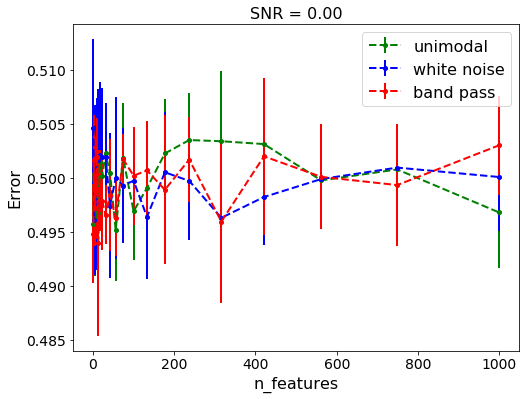

In [159]:
# plot
snr = a ** 2 / (1 - a ** 2)
fig = plt.figure(figsize=(8, 6))
plt.title('SNR = %0.2f' % snr, fontsize=16)
plt.errorbar(n_features, mean_gaus, yerr=std_gaus, fmt='--go', label='unimodal', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise, yerr=std_whitenoise, fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp, yerr=std_bp, fmt='--ro', label='band pass', markersize=4, lw=2)
plt.legend(fontsize=16)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/rand_classification/non_ov_windows/clf_a=%0.2f.png' % a)

plt.xlim(0, 100)
plt.savefig('figures/rand_classification/non_ov_windows/clf_a=%0.2f_zoomed.png' % a)

In [160]:
ls figures/rand_classification/

clf_a=0.01.png         clf_a=0.80.png         misclassified/
clf_a=0.01_zoomed.png  clf_a=0.80_zoomed.png  non_ov_windows/
clf_a=0.50.png         clf_a=1.00.png
clf_a=0.50_zoomed.png  clf_a=1.00_zoomed.png


In [145]:
mean_gaus

array([0.45871831, 0.44977446, 0.43003578, 0.41975424, 0.4113548 ,
       0.42675377, 0.42639602, 0.39780681, 0.36828434, 0.32076528,
       0.21852543, 0.24509255, 0.21994089, 0.15101882, 0.11807435,
       0.075035  , 0.07190854, 0.08271893, 0.08432105, 0.07473946,
       0.09007622, 0.07791258, 0.06637113])